# Problem Statement

Let's say that we want to perform a linear regression on a housing dataset to predict housing price.

Let's say that using sklearn or Excel to simply draw a regression line is beneath us.

Let's say we want to build something from the ground up, with *forward passes*, *back-propagation* and *gradient*.

That's a loooot of let's and say's. But a thousand miles journey start with one step.

## Data Import and Preprocessing

In [1]:
# Standard imports

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Specified imports

from typing import Dict, Tuple
from numpy import ndarray
from pandas import DataFrame
from sklearn.datasets import fetch_california_housing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [2]:
# Options

sns.set_style('whitegrid')

In [3]:
cali = fetch_california_housing()
df = pd.DataFrame(cali.data, columns=cali.feature_names)
df['MedHouseValue'] = pd.Series(cali.target) # add y to df for convenience
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseValue
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


For ease of computation, let's normalize the data down to a 0-1 range.

In [4]:
def normalize(df: DataFrame) -> DataFrame: # code I stole from StackOverflow
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

norm_df = normalize(df)
norm_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseValue
0,0.539668,0.784314,0.043512,0.020469,0.008941,0.001499,0.567481,0.211155,0.902266
1,0.538027,0.392157,0.038224,0.018929,0.067210,0.001141,0.565356,0.212151,0.708247
2,0.466028,1.000000,0.052756,0.021940,0.013818,0.001698,0.564293,0.210159,0.695051
3,0.354699,1.000000,0.035241,0.021929,0.015555,0.001493,0.564293,0.209163,0.672783
4,0.230776,1.000000,0.038534,0.022166,0.015752,0.001198,0.564293,0.209163,0.674638


In [5]:
X = norm_df[norm_df.columns[:-1]]
y = norm_df['MedHouseValue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Linear Regression Computational Graph

Linear Regression is often shown as the function:

$y_i = β_0 + β_1 × x_1 + ... + β_n × x_k$

Term $β_0$ is the "baseline" prediction, aka the prediction that is made when all of the features are 0. The numeric value of our target, in this case `MedHouseValue` is the combination of the *k* features of a row, or observation. Specifically, for each observation, a house, we have 8 features.

$X=\begin{bmatrix}x_1 & x_2 & ... & x_8\end{bmatrix}$

With that background, our linear regression would look like this computationally:

![Single Linear Reg](../imgs/2-2-chap2.png)

The *M* function box would multiply the corresponding feature and weight pair together, which then are all added together with a bias in the *A* function box. Finally, the $\Lambda$ function box calculate the error, or in our case, Squared Error.

This is fine and all, but we can combine the *M* and *A* box into a single matrix multiplication function with a little shift in thinking. Let's compose all the weights into a single column vector, 

$W=\begin{bmatrix}w_1 \\ w_2 \\ ... \\ w_8\end{bmatrix}$

Then our prediction would simply be $p = X × W + \beta = x_1 × w_1 + x_2 × w_2 + ... + x_8 + w_8 + \beta$

We can train in batches, so a batch of size 3 would look like:

$X_{batch}=\begin{bmatrix}x_{11} & x_{12} & ... & x_{18} \\ x_{21} & x_{22} & ... & x_{28} \\ x_{31} & x_{32} & ... & x_{38}\end{bmatrix} = \begin{bmatrix}X_1 \\ X_2 \\ X_3\end{bmatrix}$

$p_{batch}= X_{batch} × W + \beta = \begin{bmatrix}X_1 × W + \beta \\ X_2 × W + \beta \\ X_3 × W + \beta\end{bmatrix}$

When we represent the forward phase this way, we also need to remodel the $\Lambda$ box so that it returns a single value instead of an n (batch size) by 1 column vector. Just taking the mean of the row entries of the loss column vector is sufficient, so from that we have the function Mean Square Error (MSE).

Using this paradigm shift, our new computational graph looks like this:

![Matrix Linear Reg](../imgs/2-4-chap2.png)

## Linear Regression Forward Pass

In [6]:
def forward_pass(X_batch: ndarray,
                 y_batch: ndarray,
                 weights: ndarray,
                 bias: float) -> Tuple[float, Dict[str, ndarray]]:
    """
    Perform forward pass for linear regression according to the matrix multiplication computational graph
    """
    
    assert X_batch.shape[0] == y_batch.shape[0]
    assert X_batch.shape[1] == weights.shape[0]
    
    info = dict()
    
    N = np.dot(X_batch, weights) # nu
    P = N + bias # prediction
    
    loss = np.mean(np.power(y_batch - P, 2)) # mse
    
    info['X'] = X_batch
    info['N'] = N
    info['P'] = P
    info['y'] = y_batch
    
    return loss, info

## Linear Regression Gradient Calculation

Since the “forward pass” of this function was passing the input through a series of nested functions, the backward pass will simply involve computing the *partial derivatives* of each function, evaluating those derivatives at the functions’ inputs, and multiplying them together.

![Gradient Calc Linear Reg](../imgs/2-5-chap2.png)

Let's start at the top. So we want to first evaluate $\frac{\partial\Lambda}{\partial P}$ at its input P and y. Then we want to evaluate $\frac{\partial\alpha}{\partial N}$ at N & B, then $\frac{\partial\nu}{\partial W}$ at X & W. Finally, we multiply all of these derivatives together to obtain the *gradient* to update the weight (W) vector.

$\frac{\partial\Lambda}{\partial P}(P, y) × \frac{\partial\alpha}{\partial N}(N, B) ×\frac{\partial\nu}{\partial W}(X, W)$

We can repeat this process with $\frac{\partial\Lambda}{\partial P}(P, y) × \frac{\partial\alpha}{\partial B}(N, B)$ for the bias term B.

Let's first evaluate $\frac{\partial\Lambda}{\partial P}(P, y)$. Since $\Lambda(P, y) = (y - P)^2$ for each element in P and y,

$\frac{\partial\Lambda}{\partial P}(P, y) = -1 × 2 * (y - P)$

Now for $\frac{\partial\alpha}{\partial N}(N, B)$. Since $\alpha$ is just addition, increasing any element of N by 1 would increase the corresponding entry in $\alpha(N, B)$ by 1. Therefore, because N is a column vector, $\frac{\partial\alpha}{\partial N}(N, B)$ is also a column vector with every entries equal to 1. Using the same reasoning, $\frac{\partial\alpha}{\partial B}(N, B) = 1$

Finally, $\frac{\partial\nu}{\partial W}(X, W)$. This is very tricky, but due to how the multiplication work out, the partial derivative evaluates to $W^T$. In general, this simplification is applicable when computing derivatives of nested functions where one of the constituent functions is a matrix multiplication.

In conclusion, we have:

Gradients for W $=\frac{\partial\Lambda}{\partial P}(P, y) × \frac{\partial\alpha}{\partial N}(N, B) ×\frac{\partial\nu}{\partial W}(X, W) = -1 × 2 * (y - P) × \begin{bmatrix}1 \\ 1 \\ 1\\ \vdots \\ 1\end{bmatrix} × W^T$

and

Gradient for B $=\frac{\partial\Lambda}{\partial P}(P, y) × \frac{\partial\alpha}{\partial B}(N, B) = -1 × 2 * (y - P) × 1$

## Linear Regression Gradients Calculation Code

In [7]:
def loss_gradients_calc(forward_info: Dict[str, ndarray],
                        weights: ndarray,
                        bias: float) -> Dict[str, ndarray]:
    """
    Compute dLdW and dLdB for linear regression
    """
    
    dLdP = -1 * 2 * (forward_info['y'] - forward_info['P'])
    dPdN = np.ones_like(forward_info['N'])
    dPdB = np.ones_like(bias)
    dNdW = np.transpose(forward_info['X'], (1, 0))
    
    dLdN = dLdP * dPdN
    dLdW = np.dot(dNdW, dLdN) # do this in this particular way to get singular number
    
    dLdB = (dLdP * dPdB).sum(axis=0) # also to get singular number
    
    loss_grads = {}
    loss_grads['W'] = dLdW
    loss_grads['B'] = dLdB
    
    return loss_grads

## Training Functions

In [8]:
Batch = Tuple[ndarray, ndarray]

def to_2d_arr(a: ndarray, type_op: str = "col") -> ndarray:
    """
    Turn 1d tensor to 2d
    """
    
    assert a.ndim == 1
    assert type_op == "col" or type_op == "row"
    
    if type_op == "col":
        return a.reshape(-1, 1)
    else:
        return a.reshape(1, -1)
    
def shuffle_data(X: ndarray, y: ndarray) -> Batch:
    """
    Shuffle X and y using the same permutation along axis x=0
    """
    
    order = np.random.permutation(X.shape[0])
    
    return X[order], y[order]

def generate_batch(X: ndarray, y: ndarray, batch_size: int = 16, start: int = 0) -> Batch:
    """
    Generate batch from X and y given start and the size
    """
    
    # assert X.ndim == y.ndim == 2
    
    if  start+batch_size > X.shape[0]:
        batch_size = X.shape[0] - start
    
    X_batch, y_batch = X[start:start + batch_size], y[start:start + batch_size]
    
    return X_batch, y_batch

def init_weights(n_in: int) -> Tuple[ndarray, float]:
    """
    Initialize weights before training
    """
    
    W = np.random.randn(n_in, 1)
    B = random.random()
    
    return W, B

In [9]:
def train(X: ndarray, y: ndarray, epochs: int = 1000, batch_size: int = 16, learning_rate: float = 0.001, return_info: bool = False, seed: int = 69) -> None:
    """
    Initialize and train a linear regression algorithm in 1000 epochs,
    each epoch is a forward pass and back-propagation of one batch
    """
    
    if seed:
        np.random.seed(seed)
        
    weights, bias = init_weights(X.shape[1])
    
    if return_info:
        info = dict()
        info['loss'] = list()
    
    X, y = shuffle_data(X, y)
    start = 0
    for epoch in range(epochs):
        if start >= X.shape[0]:
            X, y = shuffle_data(X, y)
            start = 0
            
        X_batch, y_batch = generate_batch(X, y, batch_size, start)
        start += batch_size
        
        loss, forward_info = forward_pass(X_batch, y_batch, weights, bias)
        
        if return_info:
            info['loss'].append(loss)
            
        loss_grads = loss_gradients_calc(forward_info, weights, bias)
        weights = weights - (learning_rate * loss_grads['W'])
        bias = bias - (learning_rate * loss_grads['B'])
        
    if return_info:
        info['W'] = weights
        return info
    
    return None

## Train Model

In [12]:
train_info = train(X_train.to_numpy(), y_train.to_numpy(), return_info=True, epochs=100)

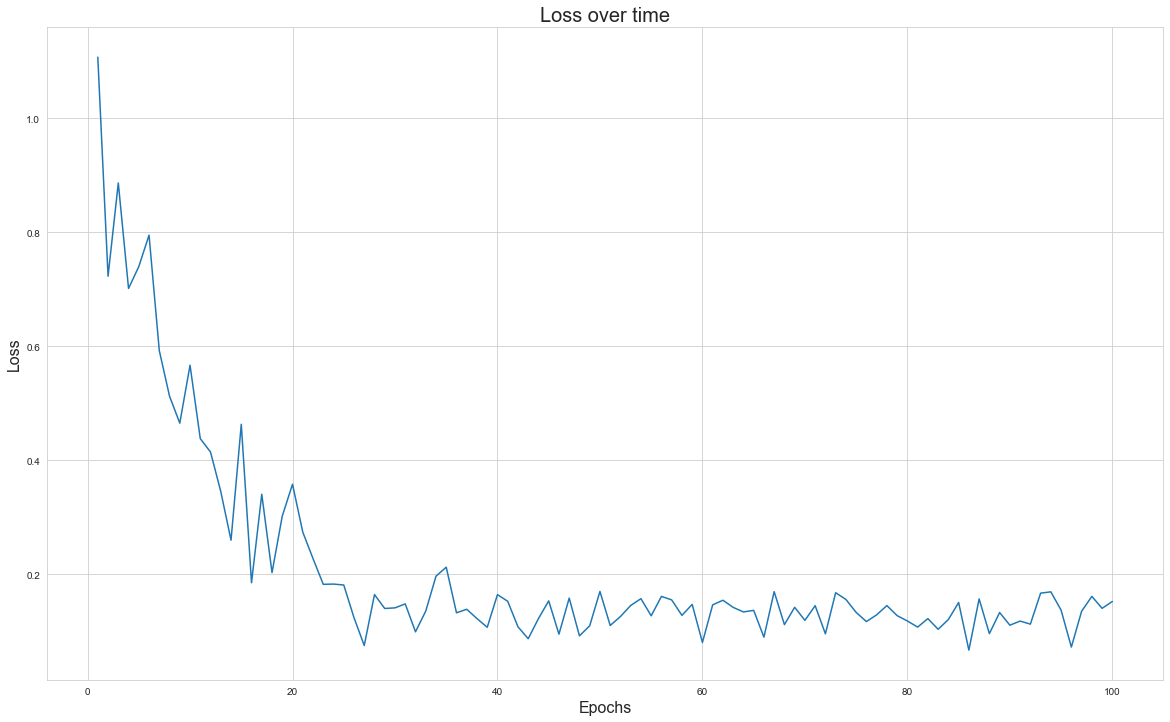

In [13]:
plt.figure(figsize=(20, 12))
plt.plot(list(range(1, 101)), train_info['loss'])
plt.title('Loss over time', fontsize=20)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=16)
plt.show()